In [1]:
dir_data = "dataset1"
dir_seg = dir_data + "/annotations_prepped_train/"
dir_img = dir_data + "/images_prepped_train/"

In [2]:
import os
import glob

all_img_paths = glob.glob(os.path.join(dir_img, "*.png"))
print(all_img_paths[:5])

all_mask_paths = glob.glob(os.path.join(dir_seg, "*.png"))
print(all_mask_paths[:5])

['dataset1/images_prepped_train/0001TP_008460.png', 'dataset1/images_prepped_train/0016E5_08490.png', 'dataset1/images_prepped_train/0016E5_06330.png', 'dataset1/images_prepped_train/0006R0_f02550.png', 'dataset1/images_prepped_train/0016E5_02340.png']
['dataset1/annotations_prepped_train/0001TP_008460.png', 'dataset1/annotations_prepped_train/0016E5_08490.png', 'dataset1/annotations_prepped_train/0016E5_06330.png', 'dataset1/annotations_prepped_train/0006R0_f02550.png', 'dataset1/annotations_prepped_train/0016E5_02340.png']


In [21]:
import cv2
import imageio

x = []
y = []

for i in range(len(all_img_paths)):
    img = cv2.imread(all_img_paths[i])
    img = cv2.resize(img, (224, 224))

    mask_path = dir_seg + all_mask_paths[i].split('/')[-1]
    img_mask = imageio.imread(mask_path)
    img_mask = cv2.resize(img_mask, (224, 224))

    x.append(img)
    y.append(img_mask)

    if (i % 100 == 0):
        print(i)

/var/folders/08/wh2xr5050kq2g5wcmx_r3vhh0000gn/T/ipykernel_49931/1677203040.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img_mask = imageio.imread(mask_path)


0
100
200
300


In [22]:
import numpy as np

x = np.array(x)
y = np.array(y)
print(f"X: {x.shape}")
print(f"y: {y.shape}")

X: (367, 224, 224, 3)
y: (367, 224, 224)


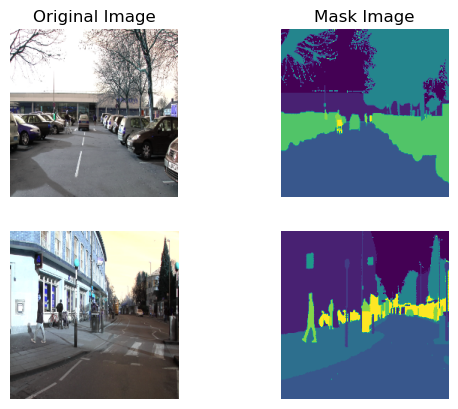

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.subplot(221)
plt.imshow(x[3])
plt.axis('off')
plt.title('Original Image')
plt.grid('off')

plt.subplot(222)
plt.imshow(y[3])
plt.axis('off')
plt.title('Mask Image')
plt.grid('off')

plt.subplot(223)
plt.imshow(x[1])
plt.axis('off')
plt.grid('off')

plt.subplot(224)
plt.imshow(y[1])
plt.axis('off')
plt.grid('off')

plt.show()

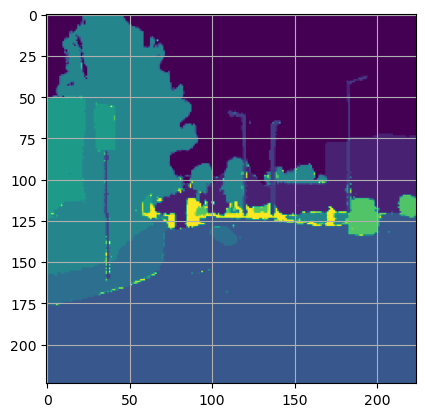

In [24]:
%matplotlib inline

plt.imshow(img_mask)
plt.grid()
plt.show()

In [25]:
set(y.flatten())

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}

In [26]:
print(y.shape)

(367, 224, 224)


In [27]:
n_classes = len(set(y.flatten()))
print(n_classes)

12


In [28]:
def getsegnum(img):
    seg_labels = np.zeros((224, 224, 12))
    for c in range(n_classes):
        seg_labels[:,:,c] = (img == c).astype(int)
    return seg_labels

In [29]:
y2 = []
for i in range(len(y)):
    y2.append(getsegnum(y[i]))

In [30]:
y2 = np.array(y2)
print(y2.shape)
print(np.unique(y2))

(367, 224, 224, 12)
[0. 1.]


In [31]:
x = x / 255.
print(np.max(x))

1.0


In [32]:
from tensorflow.keras.applications.vgg16 import VGG16

base_vgg16 = VGG16(
    include_top=False, input_shape=(224, 224, 3), weights='imagenet'
)
base_vgg16.trainable = False

In [33]:
from tensorflow.keras.layers import Input, Dropout, Flatten, Conv2D, MaxPooling2D, UpSampling2D, concatenate, BatchNormalization
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.models import Model

In [34]:
conv1 = Model(
    inputs=base_vgg16.input, outputs=base_vgg16.get_layer('block1_conv2').output
).output
conv2 = Model(
    inputs=base_vgg16.input, outputs=base_vgg16.get_layer('block2_conv2').output
).output
conv3 = Model(
    inputs=base_vgg16.input, outputs=base_vgg16.get_layer('block3_conv3').output
).output
conv4 = Model(
    inputs=base_vgg16.input, outputs=base_vgg16.get_layer('block4_conv3').output
).output
drop4 = Dropout(0.5)(conv4)
conv5 = Model(
    inputs=base_vgg16.input, outputs=base_vgg16.get_layer('block5_conv3').output
).output
drop5 = Dropout(0.5)(conv5)

In [38]:
up6 = Conv2D(
    512, 2, padding='same', activation='relu', kernel_initializer='he_normal'
)(UpSampling2D(size=(2, 2))(drop5))
merge6 = concatenate([drop4, up6], axis=-1)
conv6 = Conv2D(
    512, 3, padding='same', activation='relu', kernel_initializer='he_normal'
)(merge6)
conv6 = Conv2D(
    512, 3, padding='same', activation='relu', kernel_initializer='he_normal'
)(conv6)
conv6 = BatchNormalization()(conv6)

up7 = Conv2D(
    256, 2, padding='same', activation='relu', kernel_initializer='he_normal'
)(UpSampling2D(size=(2, 2))(conv6))
merge7 = concatenate([conv3, up7], axis=-1)
conv7 = Conv2D(
    256, 3, padding='same', activation='relu', kernel_initializer='he_normal'
)(merge7)
conv7 = Conv2D(
    256, 3, padding='same', activation='relu', kernel_initializer='he_normal'
)(conv7)
conv7 = BatchNormalization()(conv7)

up8 = Conv2D(
    128, 2, padding='same', activation='relu', kernel_initializer='he_normal'
)(UpSampling2D(size=(2, 2))(conv7))
merge8 = concatenate([conv2, up8], axis=-1)
conv8 = Conv2D(
    128, 3, padding='same', activation='relu', kernel_initializer='he_normal'
)(merge8)
conv8 = Conv2D(
    128, 3, padding='same', activation='relu', kernel_initializer='he_normal'
)(conv8)
conv8 = BatchNormalization()(conv8)

up9 = Conv2D(
    64, 2, padding='same', activation='relu', kernel_initializer='he_normal'
)(UpSampling2D(size=(2, 2))(conv8))
merge9 = concatenate([conv1, up9], axis=-1)
conv9 = Conv2D(
    64, 3, padding='same', activation='relu', kernel_initializer='he_normal'
)(merge9)
conv9 = Conv2D(
    64, 3, padding='same', activation='relu', kernel_initializer='he_normal'
)(conv9)
conv9 = Conv2D(
    64, 3, padding='same', activation='relu', kernel_initializer='he_normal'
)(conv9)
conv9 = BatchNormalization()(conv9)

conv10 = Conv2D(
    12, 1, activation='softmax'
)(conv9)

In [39]:
model = Model(inputs=base_vgg16.input, outputs=conv10)
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 224, 224, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 224, 224, 64  36928       ['block1_conv1[0][0]']           
                                )                                                           

In [40]:
for layer in model.layers[:18]:
    layer.trainable = False

In [41]:
model.compile(
    optimizer=Adam(learning_rate=1e-3, decay=1e-6), loss='categorical_crossentropy', metrics=['accuracy']
)

In [42]:
history = model.fit(
    x, y2, epochs=10, batch_size=16, validation_split=0.1
)

Epoch 1/10


2024-11-19 21:10:20.609142: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


21/21 [==============================] - 86s 4s/step - loss: 1.2192 - accuracy: 0.6623 - val_loss: 18.6862 - val_accuracy: 0.5370
Epoch 2/10
21/21 [==============================] - 85s 4s/step - loss: 0.7150 - accuracy: 0.8011 - val_loss: 3.0558 - val_accuracy: 0.7238
Epoch 3/10
21/21 [==============================] - 86s 4s/step - loss: 0.6015 - accuracy: 0.8287 - val_loss: 2.0870 - val_accuracy: 0.7165
Epoch 4/10
21/21 [==============================] - 85s 4s/step - loss: 0.5605 - accuracy: 0.8398 - val_loss: 1.3079 - val_accuracy: 0.6891
Epoch 5/10
21/21 [==============================] - 83s 4s/step - loss: 0.5433 - accuracy: 0.8441 - val_loss: 1.0089 - val_accuracy: 0.7401
Epoch 6/10
21/21 [==============================] - 83s 4s/step - loss: 0.5060 - accuracy: 0.8552 - val_loss: 0.9135 - val_accuracy: 0.7948
Epoch 7/10
21/21 [==============================] - 83s 4s/step - loss: 0.4787 - accuracy: 0.8631 - val_loss: 0.7802 - val_accuracy: 0.8231
Epoch 8/10
21/21 [============

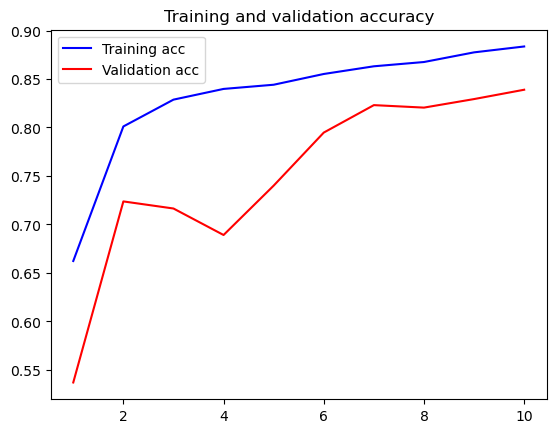

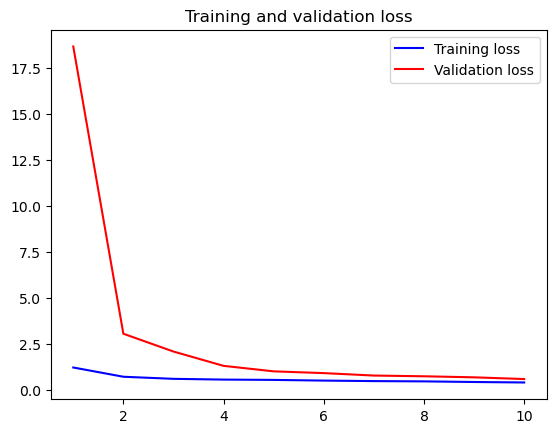

In [43]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [44]:
y_pred = model.predict(x[-2:])
y_predi = np.argmax(y_pred, axis=-1)
y_testi = np.argmax(y2[-2:], axis=-1)

print(y_predi.shape)

1/1 [==============================] - 0s 323ms/step
(2, 224, 224)


In [45]:
print(np.mean(y_predi == y_testi))

0.8755082110969388


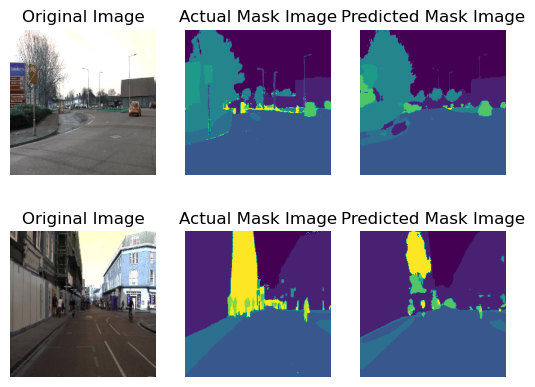

In [46]:
%matplotlib inline

plt.subplot(231)
plt.imshow(x[-1])
plt.axis('off')
plt.title('Original Image')
plt.grid('off')
plt.subplot(232)
plt.imshow(y[-1])
plt.axis('off')
plt.title('Actual Mask Image')
plt.grid('off')
plt.subplot(233)
plt.imshow(y_predi[-1])
plt.axis('off')
plt.title('Predicted Mask Image')
plt.grid('off')
plt.subplot(234)
plt.imshow(x[-2])
plt.axis('off')
plt.title('Original Image')
plt.grid('off')
plt.subplot(235)
plt.imshow(y[-2])
plt.axis('off')
plt.title('Actual Mask Image')
plt.grid('off')
plt.subplot(236)
plt.imshow(y_predi[-2])
plt.axis('off')
plt.title('Predicted Mask Image')
plt.grid('off')
plt.show()